In [2]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [4]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import ActivityNetCap2Instances
import seaborn as sns
import pickle as pkl
import json
import neptune
sns.set_style("white")

In [5]:
# load ground truth test set
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [7]:
project = neptune.init("mayu-ot/moment-retrieval")
exp_id = "MOM-10"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}76.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}76.json", f"tmp/{exp_id}")
    print("done!")

downloading results ...
done!


In [8]:
def get_duration(video_id):
    for x in test_data:
        if x[0][0] == video_id:
            return x[1][-1]

def get_evaluation_results(predictions):
    preds = []
    for p in predictions:
        query = (p[0], p[2])
        video_duration = get_duration(query[0])
        seg = [s + [video_duration] for s in p[3][:5]]
        preds.append((query, seg, p[5][:5]))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

In [9]:
predictions = json.load(open(f"tmp/{exp_id}/{exp_id}76.json"))
results, summary = get_evaluation_results(predictions)

151 missing instances
missing item: ('v_uqiMw7tQ1Cc', ' One man is holding onto a rope attached to a machine, and the other man instructs him to bend down on his left knee while still holding onto the rope and he showing the man how to have proper form.')
missing item: ('v_5qsXmDi8d74', 'The two sumo men are in the sumo ring with the referee in the middle of them off to the side and they begin to wrestle one another trying to push each other out of the ring while the referee runs from side to side to monitor the situations.')
missing item: ('v_5qsXmDi8d74', ' Eventually the taller sumo pushes the smaller guy out of the ring and they fall a little into the audience but both remain on their feet and go back onto the ring to catch their breaths and have the referee announce the winner.')
missing item: ('v_koEfnIoZB_4', '  A person wearing a bungee jumping harness and attached to a long rope jumps from the ledge of a stone tunnel and falls many feet below to just above the ground where the

Note that SCDM discards samples whose descriptions are longer than 35 words ([GitHub repo.](https://github.com/yytzsy/SCDM/blob/e13606c735e657574440d909d766b4e3393b0625/grounding/ActivityNet/data_preparation/generate_anet_data.py#L138)).
This results in missing samples in the test set.

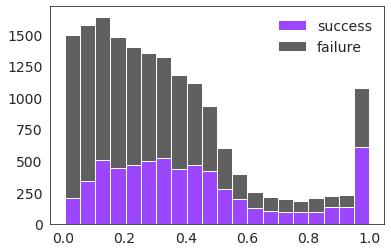

In [13]:
# Check relation between success rates and iput video durations
plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data, ax=plt.gca())

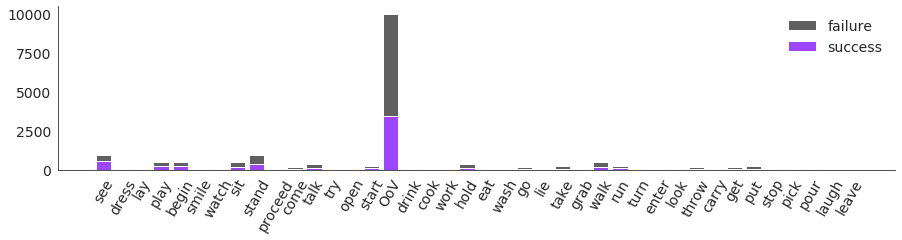

In [14]:
# per-action performance
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.utils import _load_top_actions

top_actions = _load_top_actions("charade")
cat_fn = lambda x: get_first_action(x, top_actions)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if metrics_per_cls[label]["n_instance"] > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})

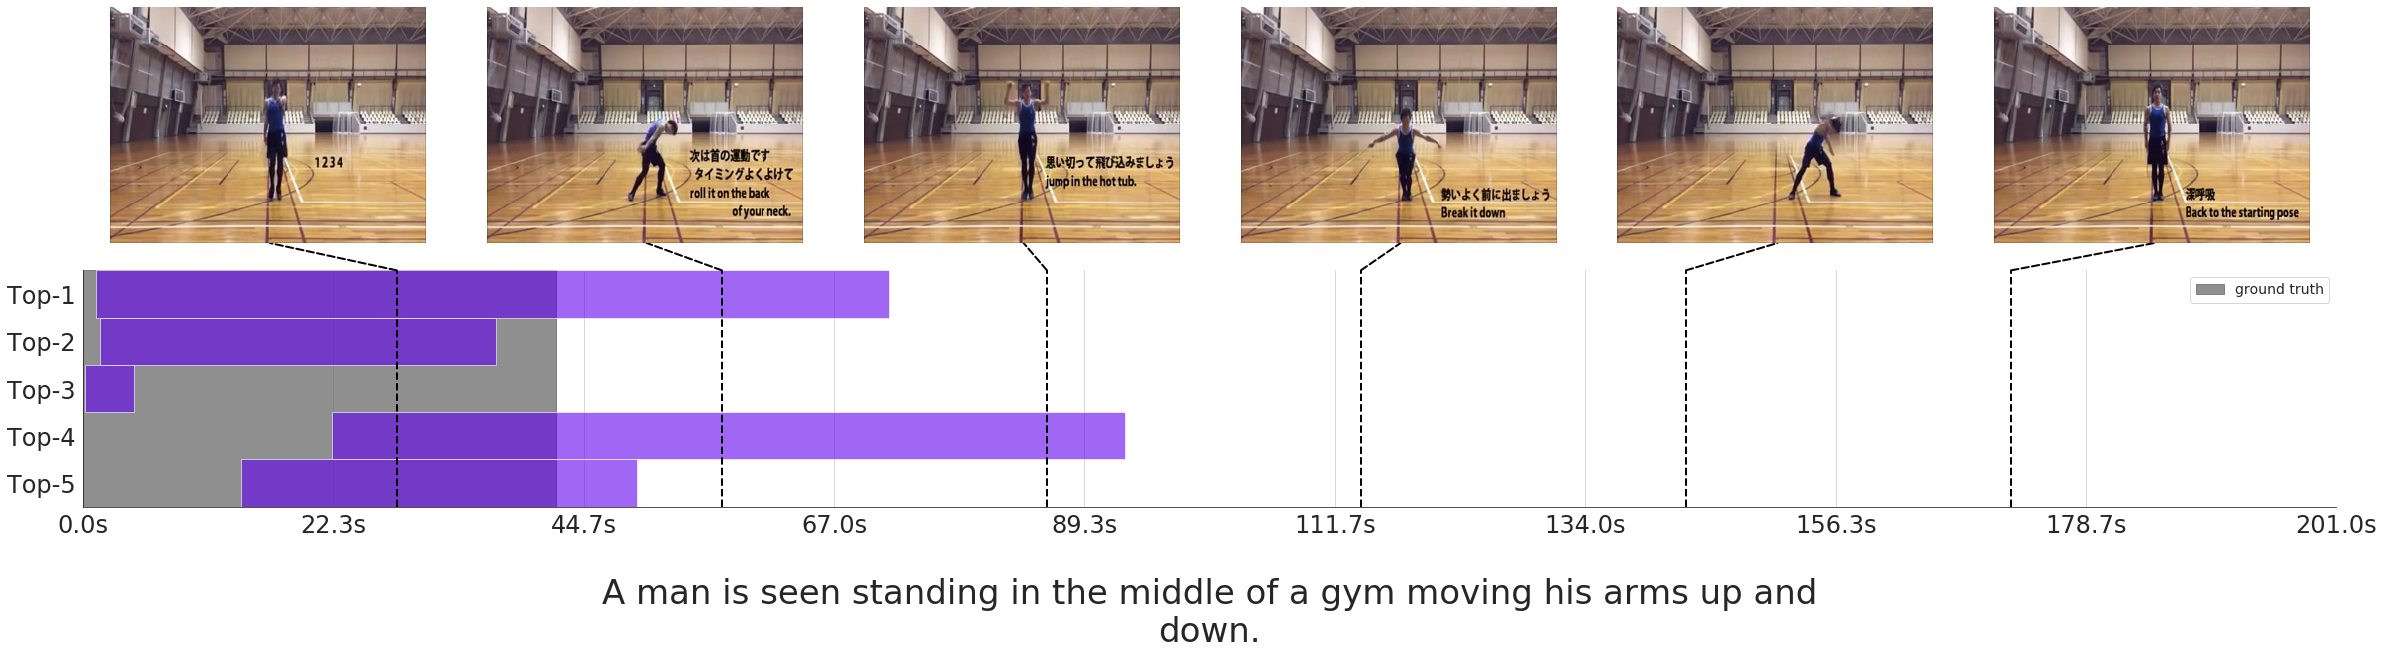

In [48]:
from IPython.display import Video, HTML
from matplotlib.patches import ConnectionPatch
from textwrap import wrap

sns.set_style("white")
f = plt.figure(figsize=(11*3, 3*3), constrained_layout=True)

gs = f.add_gridspec(2, 6)

i = np.random.randint(len(results))
for x in test_data:
    if x[0] == results[i][0]:
        gt = x
        break
video_id, description = gt[0]
predicted_moments = results[i][1]
length = gt[1][-1]
gt_st, gt_ed = gt[1][:2]

frame_dir = f'/home/otani_mayu/3TDisk/Data/ActivityNetCap/activitynet_frames/{video_id}/'
n_frame = len(os.listdir(frame_dir))
sample_sec = np.linspace(0, int(length), 8).astype("i")
sample_sec = sample_sec[1:-1]
frames = [f'{frame_dir}{int(n_frame / length * sec):0>6}.jpg' for sec in sample_sec]

ax_timeline= f.add_subplot(gs[1, :])

for i, frame in enumerate(frames):
    img_ax = f.add_subplot(gs[0, i])
    im = plt.imread(frame)
    img_ax.imshow(im)
    img_ax.axis("off")
    h, w, _ = im.shape
    con = ConnectionPatch(xyA=[sample_sec[i], 1], xyB=[w*0.5, 0], coordsA="data", coordsB="axes points",
                      axesA=ax_timeline, axesB=img_ax, color='k', linestyle="--", linewidth=2)
    ax_timeline.add_artist(con)


ax_timeline.axvspan(gt_st, gt_ed, color="#606060", alpha=0.7, label="ground truth")
ax_timeline.set_xlim([0, length])

y = 0
for st, ed, _ in predicted_moments[::-1]:
    ax_timeline.axvspan(st, ed,
               y,y+0.2,
               facecolor='#6002ee',
                alpha=0.6
               )
    y += 0.2

for s in sample_sec:
    ax_timeline.axvline(s, linestyle="--", color="k", linewidth=2)
    
ax_timeline.set_xticks(np.linspace(0, length, 10))
ax_timeline.set_xticklabels([f'{s:.1f}s' for s in np.linspace(0, length, 10)], fontsize=24)
ax_timeline.set_yticks(np.linspace(0.1, 0.9, 5))
ax_timeline.set_yticklabels([f'Top-{a_id}' for a_id in [5,4,3,2,1]], fontsize=24)
ax_timeline.xaxis.grid()
sns.despine()
plt.sca(ax_timeline)

description = "\n".join(wrap(description))
plt.text(0.5*length,-0.3, description, fontsize=34, ha="center", va="top", wrap=True)
plt.legend()
# plt.savefig(f'reports/figures/human_annotation/{hitid}.pdf',
#            bbox_inches='tight')

HTML(f"""
     <iframe id="ytplayer" type="text/html" width="640" height="360"
  src="https://www.youtube.com/embed/{video_id[2:]}"
  frameborder="0"></iframe>
     """)